In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import chain
from random import sample 
import scipy

import pydicom
import skimage
##Import any other packages you may need here

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
45391,00011632_019.png,Edema|Infiltration|Nodule,19,11632,57,M,AP,2500,2048,0.168,0.168,NaN
81421,00020005_000.png,No Finding,0,20005,35,F,PA,2522,2991,0.143,0.143,NaN
50237,00012704_015.png,Nodule,15,12704,36,F,PA,2590,2991,0.143,0.143,NaN


In [3]:
## EDA

In [4]:
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
110198,00029994_000.png,No Finding,0,29994,20,F,PA,2021,2021,0.194311,0.194311,NaN
80870,00019871_005.png,Mass,5,19871,76,M,PA,2992,2991,0.143000,0.143000,NaN
1146,00000280_003.png,Pleural_Thickening,3,280,46,M,PA,2992,2991,0.143000,0.143000,NaN


In [5]:
## Going to split up "Finding Labels" column so that there's one column in the dataframe
# per disease, with a binary flag. This makes EDA easier 

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
58602,00014505_000.png,No Finding,0,14505,46,F,PA,2698,2325,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
47820,00012119_002.png,No Finding,2,12119,48,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
62609,00015505_001.png,Atelectasis|Infiltration,1,15505,27,M,PA,2928,2596,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
#Remove age outliers (max age incorrectly shows 414)
xray_age = all_xray_df[all_xray_df['Patient Age'] < 130]
xray_age.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,Atelectasis,Cardiomegaly,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
count,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,0.0,112104.000000,112104.000000,...,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000
mean,8.574172,14345.720724,46.872574,2646.035253,2486.393153,0.155651,0.155651,NaN,0.103101,0.024763,...,0.022443,0.015040,0.002025,0.177433,0.051550,0.538366,0.056474,0.030186,0.012756,0.047286
std,15.406734,8403.980520,16.598152,341.243771,401.270806,0.016174,0.016174,NaN,0.304092,0.155402,...,0.148121,0.121711,0.044954,0.382037,0.221118,0.498528,0.230836,0.171100,0.112220,0.212252
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,NaN,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,7308.000000,35.000000,2500.000000,2048.000000,0.143000,0.143000,NaN,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,NaN,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,NaN,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,183.000000,30805.000000,95.000000,3827.000000,4715.000000,0.198800,0.198800,NaN,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
xray_age[all_labels].sum()/len(xray_age)

Atelectasis           0.103101
Cardiomegaly          0.024763
Consolidation         0.041631
Edema                 0.020535
Effusion              0.118783
Emphysema             0.022443
Fibrosis              0.015040
Hernia                0.002025
Infiltration          0.177433
Mass                  0.051550
No Finding            0.538366
Nodule                0.056474
Pleural_Thickening    0.030186
Pneumonia             0.012756
Pneumothorax          0.047286
dtype: float64

[Text(0, 0.5, 'Number of Images with Label')]

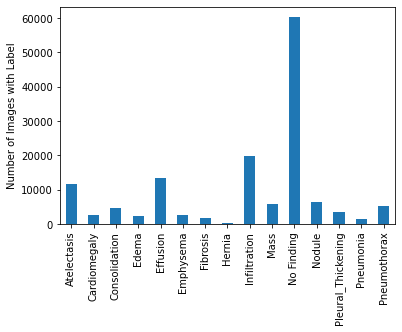

In [8]:
ax = xray_age[all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

Above, the relative frequencies of each disease in xray_age dataset. It looks like 'No Finding' is the most common occurrence. 'No Finding' can never appear with any other label by definition, so we know that in 53.8% of this dataset, there is no finding in the image. Beyond that, it appears that 'Pneumonia' disease-related label is 1.27%.

Now looking at how frequently Pneumonia appears with all of the other diseases:

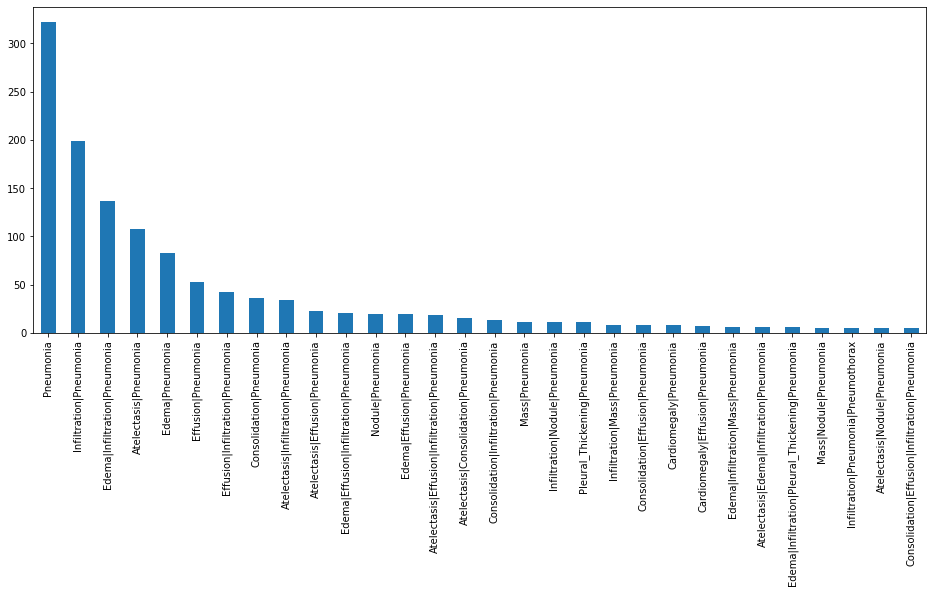

In [9]:
##Since there are many combinations of potential findings, I'm going to look at the 30 most common co-occurrences:
plt.figure(figsize=(16,6))
xray_age[xray_age.Pneumonia==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')
plt.savefig('EDA_cooccurence.png')

It looks like Pneumonia occurs alone for the most part, and that its most-common comorbidities are Infiltration, Edema/Infiltration, and Atelectasis.

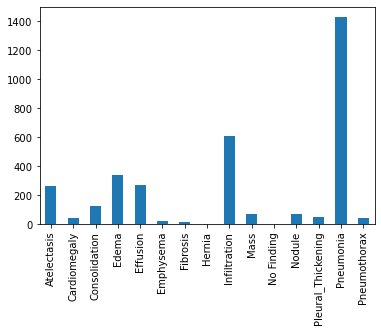

In [10]:
xray_age[xray_age.Pneumonia==1][all_labels].sum().plot(kind='bar')

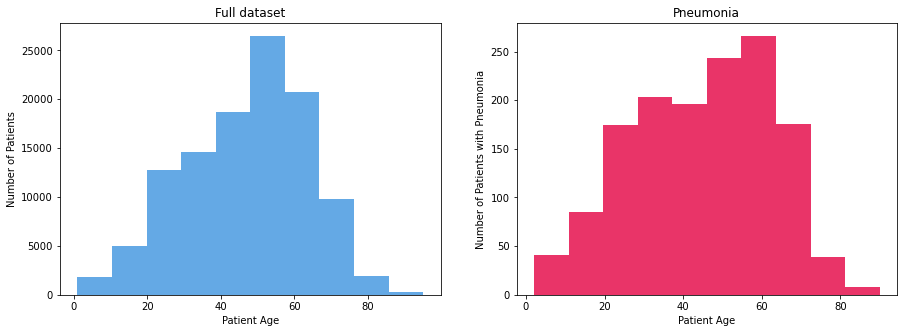

In [11]:
#Patient age distribution

fig, a = plt.subplots(1,2, figsize=(15,5))
a[0].set_title('Full dataset')
a[0].hist(xray_age['Patient Age'], color='#64A9E5')
a[0].set_ylabel('Number of Patients')
a[0].set_xlabel('Patient Age')

a[1].set_title('Pneumonia')
a[1].hist(xray_age[xray_age.Pneumonia==1]['Patient Age'], color='#E93468')
a[1].set_ylabel('Number of Patients with Pneumonia')
a[1].set_xlabel('Patient Age')

plt.savefig('patient_age.png')
plt.show()


Full dataset age range from 1 y/o to 95 y/o, with a higher representation in age group 20-70 y/o

Patients labelled as Pneumonia patients can be seen in a wide range of age group with patients as young as 1 year and going upto 95 years.

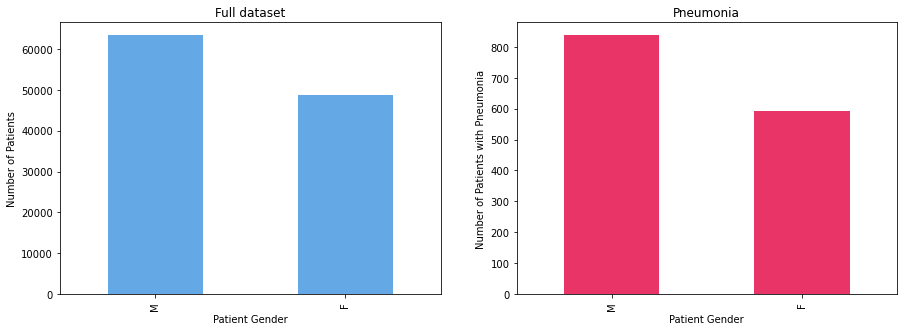

In [12]:
#Patient gender distribution

fig, a = plt.subplots(1,2, figsize=(15,5))
a[0].set_title('Full dataset')
xray_age['Patient Gender'].value_counts().plot(kind='bar', ax = a[0], color='#64A9E5')
a[0].set_ylabel('Number of Patients')
a[0].set_xlabel('Patient Gender')

a[1].set_title('Pneumonia')
xray_age[xray_age.Pneumonia==1]['Patient Gender'].value_counts().plot(kind='bar',ax = a[1], color='#E93468')
a[1].set_ylabel('Number of Patients with Pneumonia')
a[1].set_xlabel('Patient Gender')

plt.savefig('patient_gender.png')
plt.show()

The xray_age dataset (age outliers removed as they are incorrect) seems to have slightly higher percentage of male patients for overall dataset as well as for Pneumonia.

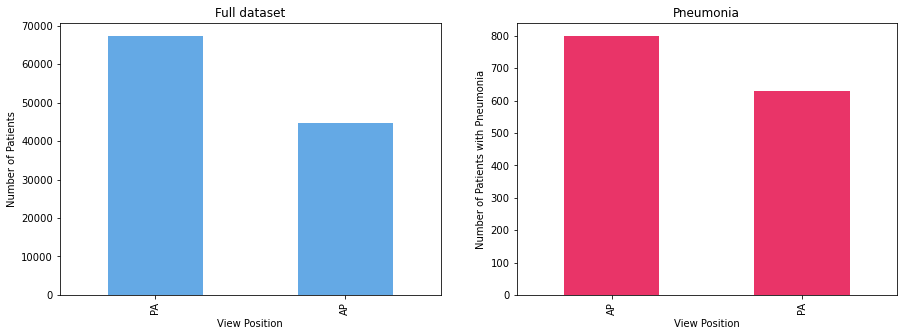

In [13]:
#Xray view position/patient position distribution:

fig, a = plt.subplots(1,2, figsize=(15,5))

a[0].set_title('Full dataset')
xray_age['View Position'].value_counts().plot(kind='bar', ax = a[0], color='#64A9E5')
a[0].set_ylabel('Number of Patients')
a[0].set_xlabel('View Position')

a[1].set_title('Pneumonia')
xray_age[xray_age.Pneumonia==1]['View Position'].value_counts().plot(kind='bar',ax = a[1], color='#E93468')
a[1].set_ylabel('Number of Patients with Pneumonia')
a[1].set_xlabel('View Position')

plt.savefig('EDA_position.png')
plt.show()

There are more xrays taken in PA position compared to AP position for full dataset, since PA is the preferred position. PA view entails X-rays penetrating through the posterior/dorsal (back) surface of a patient and being recorded on the opposite side. This is the preferred imaging orientation. Ap is the opposite of PA view and AP view XRay is commonly taken with a portable X-ray device for bed-ridden patients who are laying on their back. As seen in the above graph, Pneumonia patients have more X-Rays in AP position and thus, must be bed ridden. reference: https://www.stepwards.com/?page_id=4353

In [14]:
xray_age.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#Number of disease per patient

In [15]:
#creating new column with a sum of number of diseases for each patient id (excluding 'No finding')
cols2include = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 26]
xray_age['Total disease'] = xray_age.iloc[:, xray_age.columns.isin(xray_age.columns[cols2include])].sum(axis=1)

xray_age.iloc[:10, 12:28]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Total disease
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


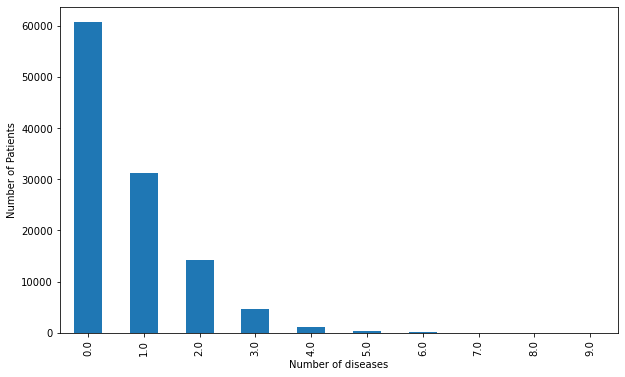

In [16]:
plt.figure(figsize=(10,6))
xray_age['Total disease'].value_counts().plot(kind='bar')

plt.ylabel('Number of Patients')
plt.xlabel("Number of diseases")
plt.show()

54.1% had no finding label i.e. 0 disease/patient. Most patients have a single disease diagnosis as seen above i.e 23.9% patients had one disease/patient.

In [17]:
xray_age['Total disease'].value_counts()/len(xray_age)

0.0    0.541238
1.0    0.278135
2.0    0.126177
3.0    0.041105
4.0    0.010196
5.0    0.002408
6.0    0.000598
7.0    0.000116
8.0    0.000018
9.0    0.000009
Name: Total disease, dtype: float64

### Pixel-level assessment with sample_labels.csv file

In [18]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
3483,00017138_110.png,Infiltration,110,17138,024Y,M,AP,2500,2048,0.168,0.168
162,00000946_000.png,No Finding,0,946,045Y,M,PA,2500,2048,0.168,0.168
2847,00014125_034.png,No Finding,34,14125,028Y,M,AP,2500,2048,0.168,0.168


In [19]:
#age is in in format '0abY' string, change it to int ab
sample_df['Patient Age'] = sample_df['Patient Age'].apply(lambda x: int(str(x)[-3:-1]))

sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
845,00004402_006.png,Atelectasis|Infiltration,6,4402,70,M,PA,3056,2544,0.139,0.139
3102,00015295_000.png,No Finding,0,15295,51,F,PA,2774,2991,0.143,0.143
4592,00022893_000.png,No Finding,0,22893,30,F,PA,2992,2833,0.143,0.143


In [20]:
## Extracting disease labels from sample_df 

sample_labels = np.unique(list(chain(*sample_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
sample_labels = [x for x in sample_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(sample_labels),sample_labels))

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [21]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation

sample_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(sample_image_paths), ', Total Headers', sample_df.shape[0])
sample_df['path'] = sample_df['Image Index'].map(sample_image_paths.get)
sample_df.sample(3)

Scans found: 112120 , Total Headers 5606


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
1269,00006681_000.png,No Finding,0,6681,48,F,PA,2048,2500,0.171,0.171,/data/images_004/images/00006681_000.png
4867,00025603_007.png,Infiltration|Pneumothorax,7,25603,45,M,PA,2992,2991,0.143,0.143,/data/images_011/images/00025603_007.png
2511,00012628_060.png,No Finding,60,12628,51,F,AP,2500,2048,0.168,0.168,/data/images_006/images/00012628_060.png


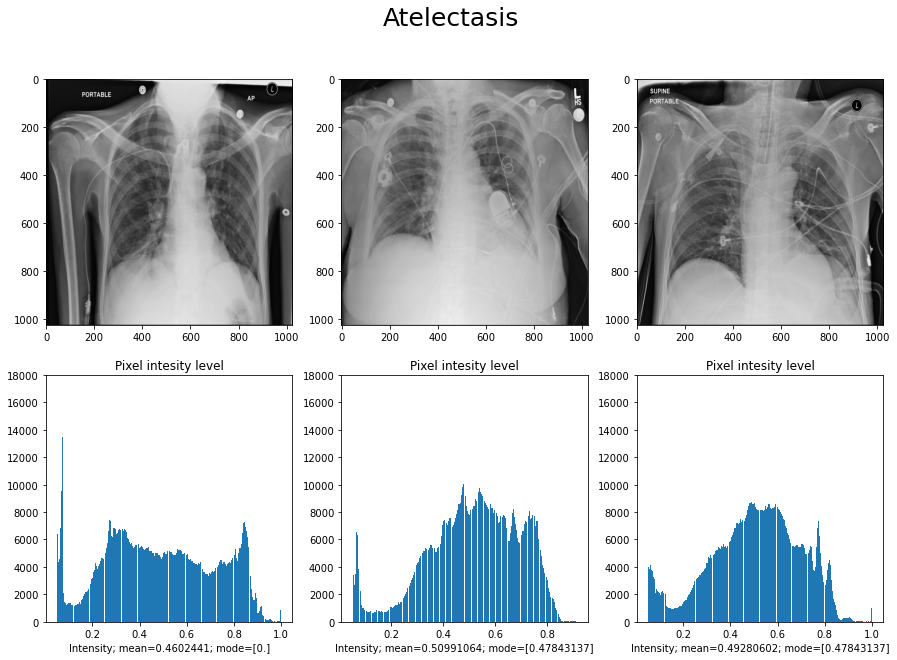

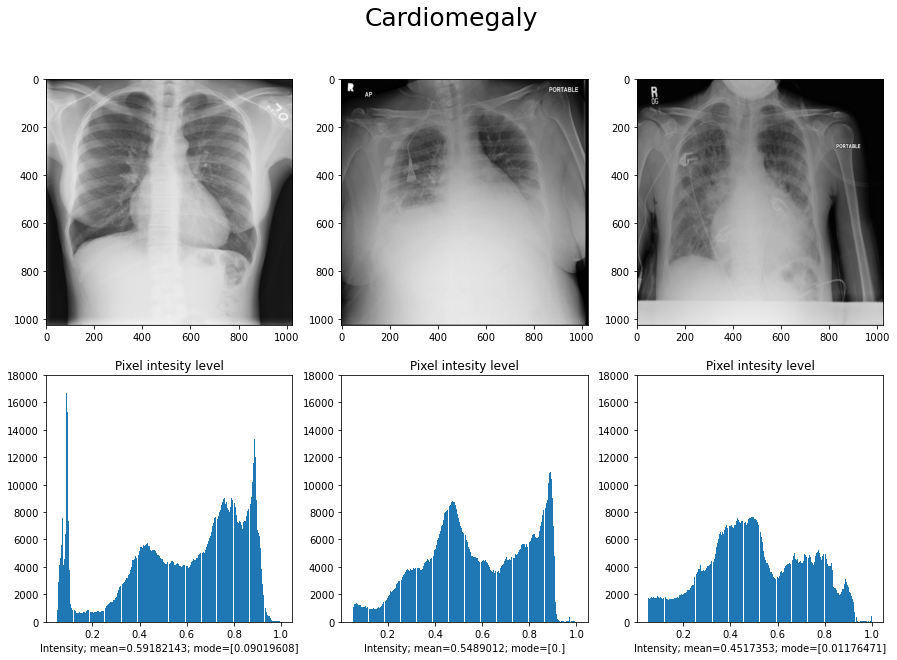

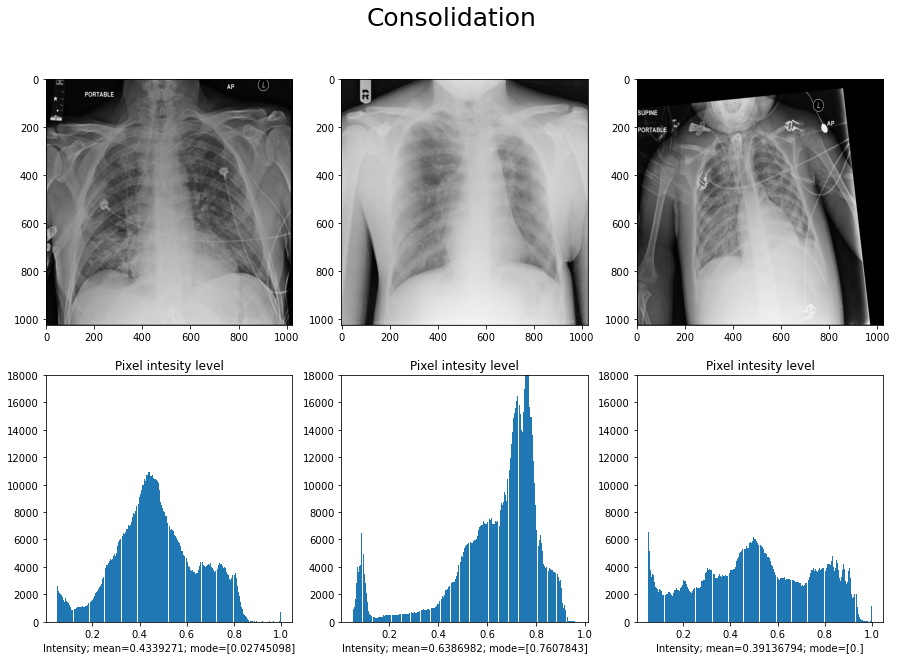

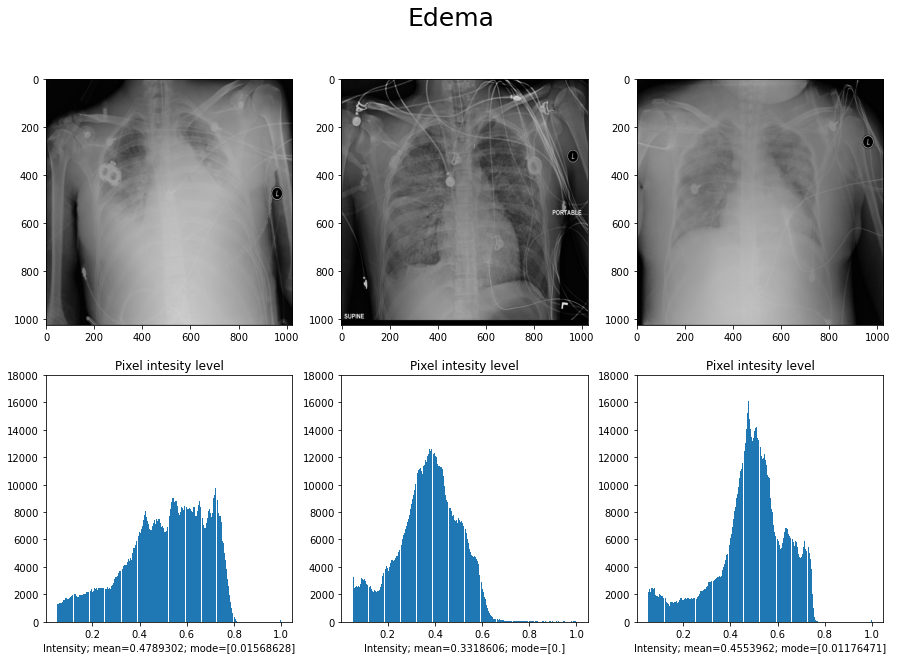

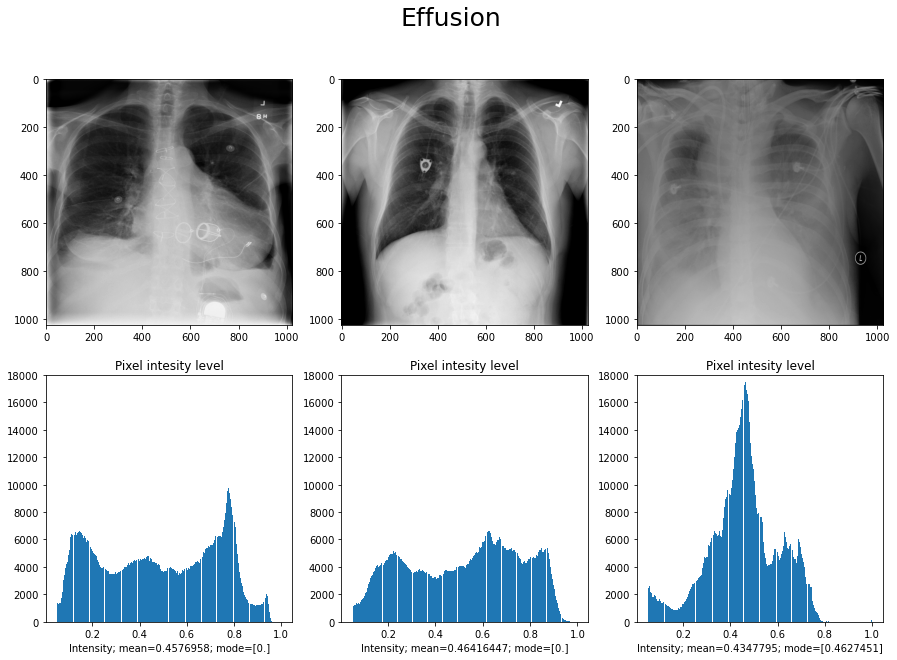

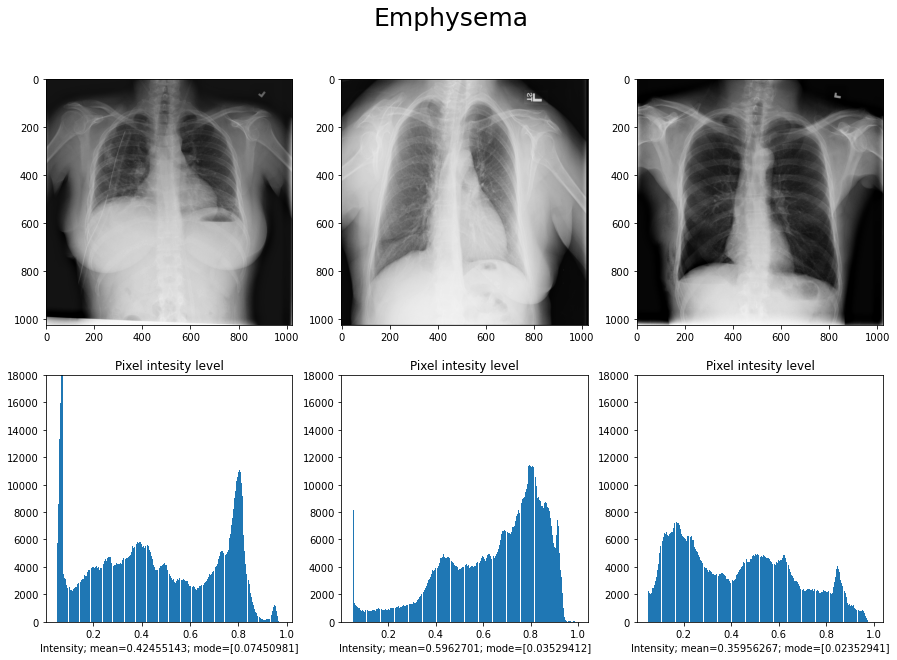

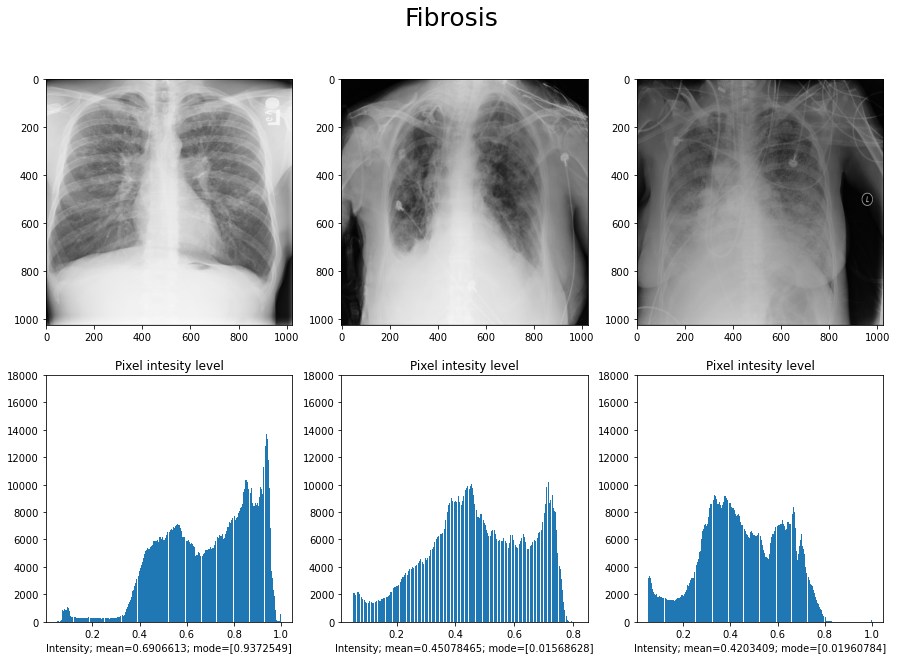

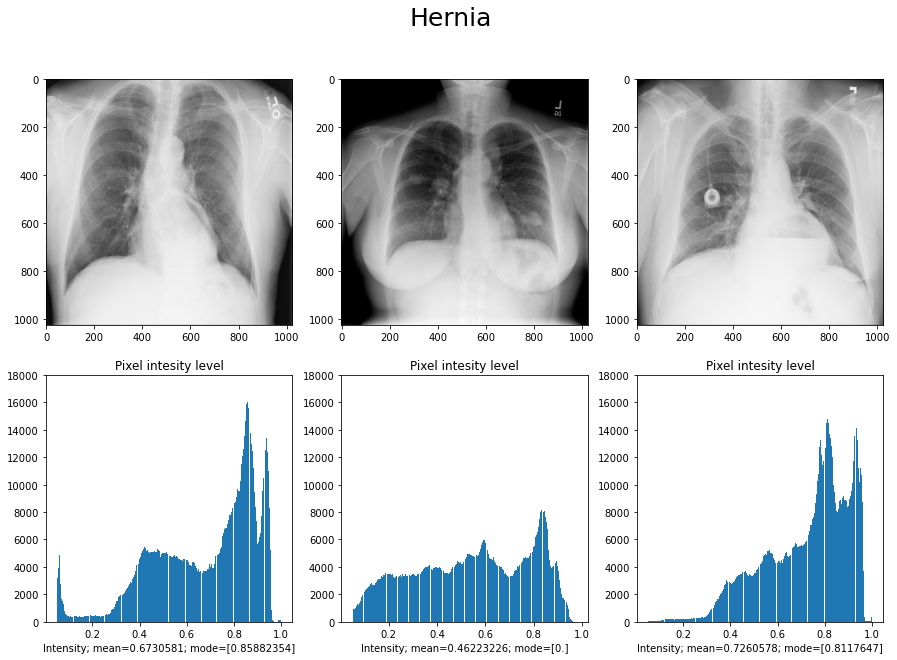

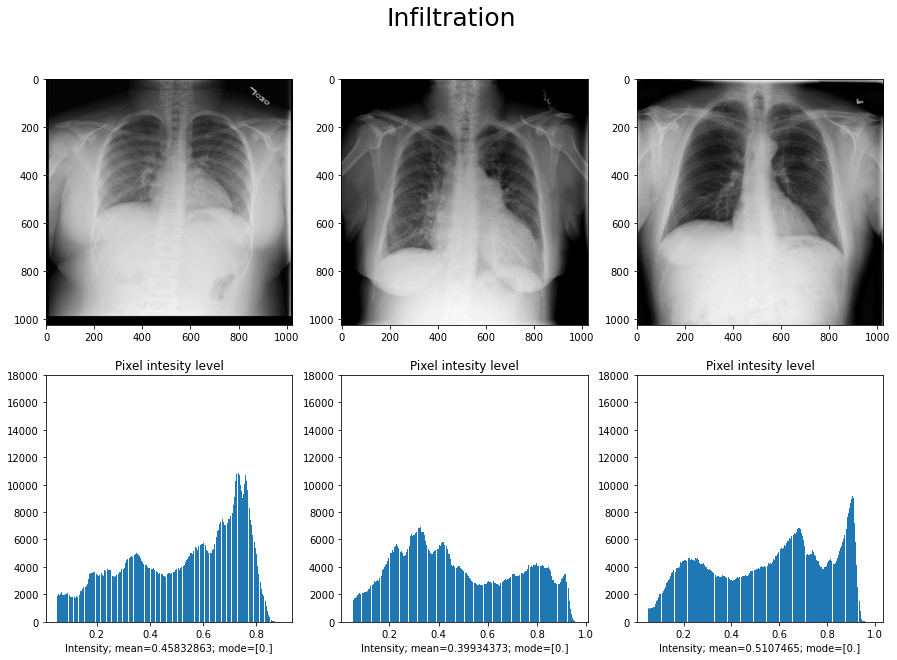

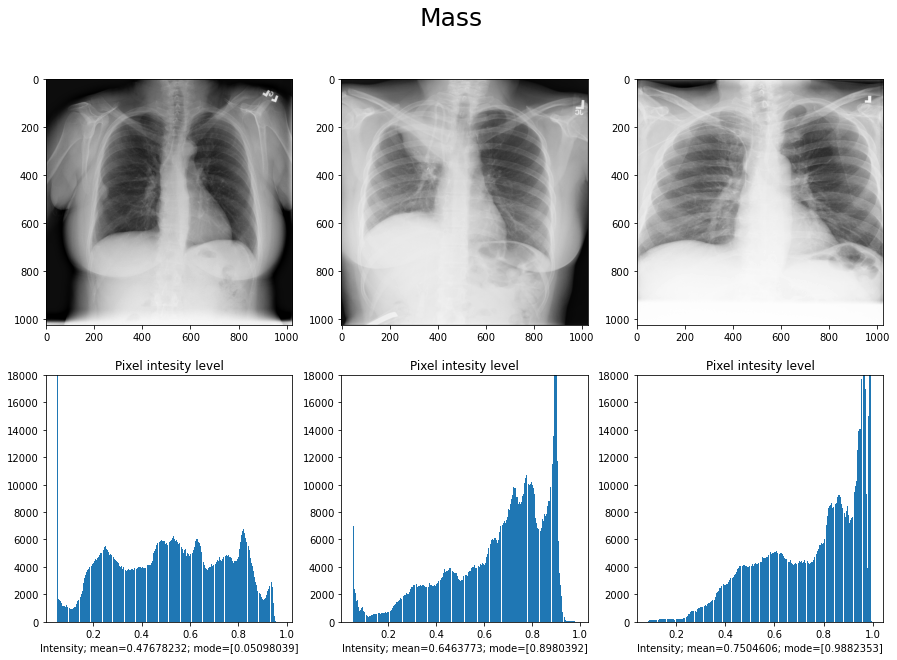

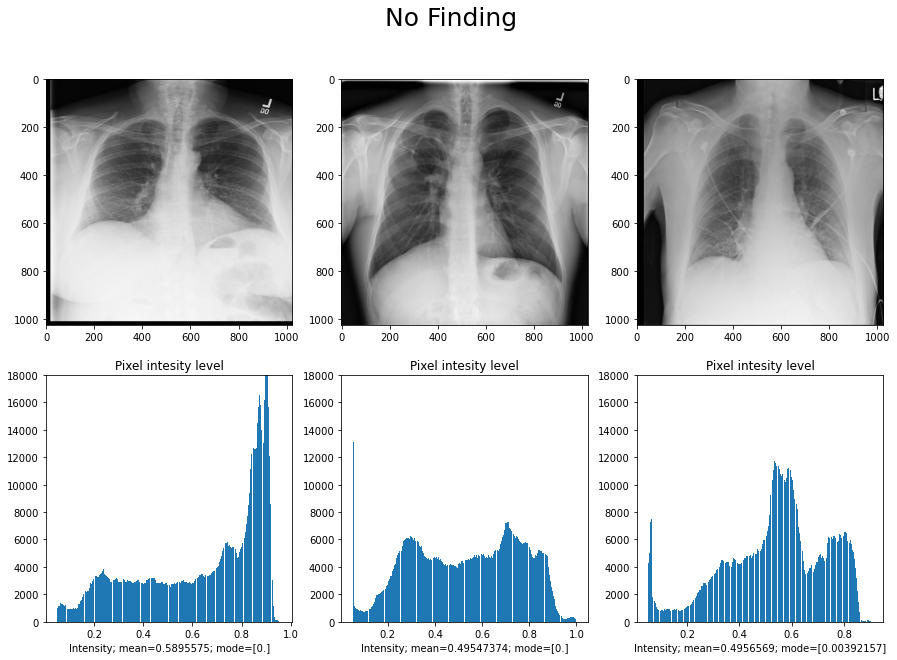

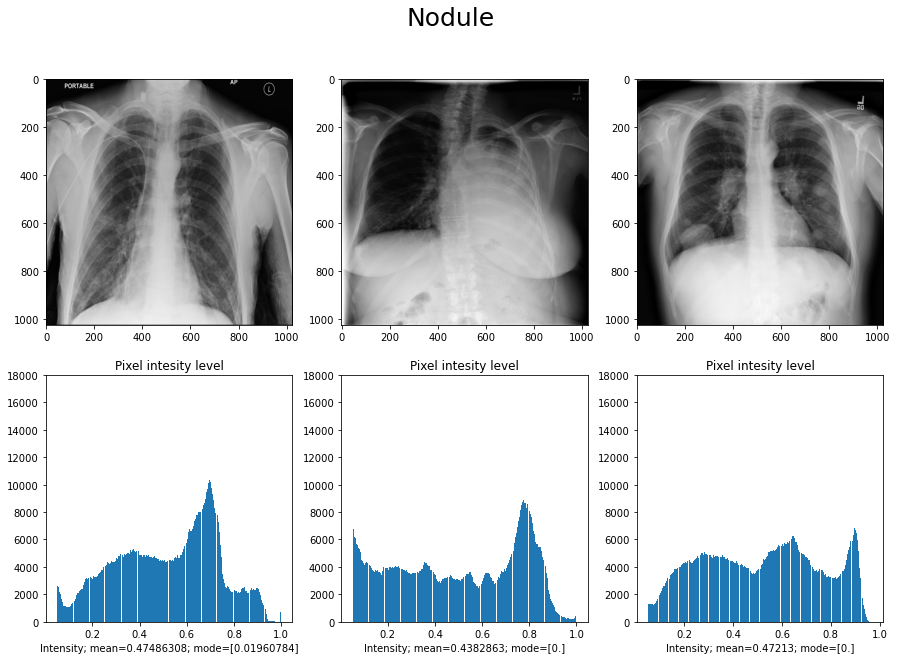

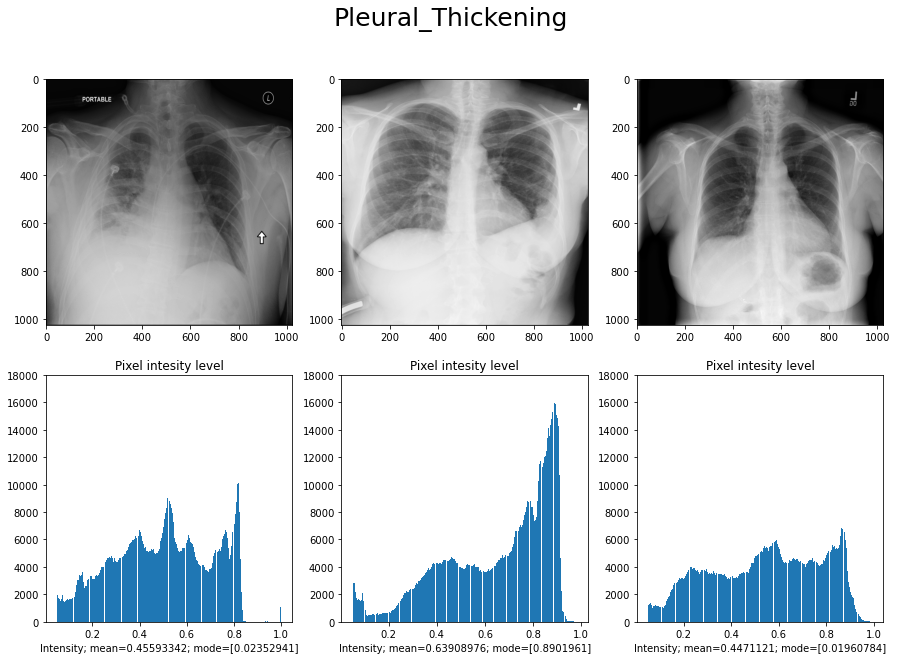

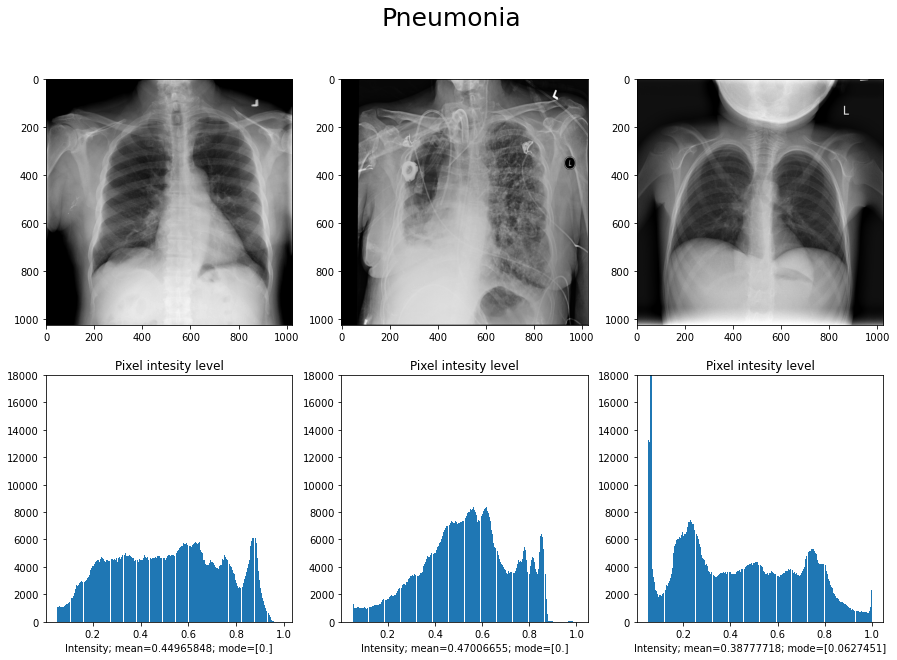

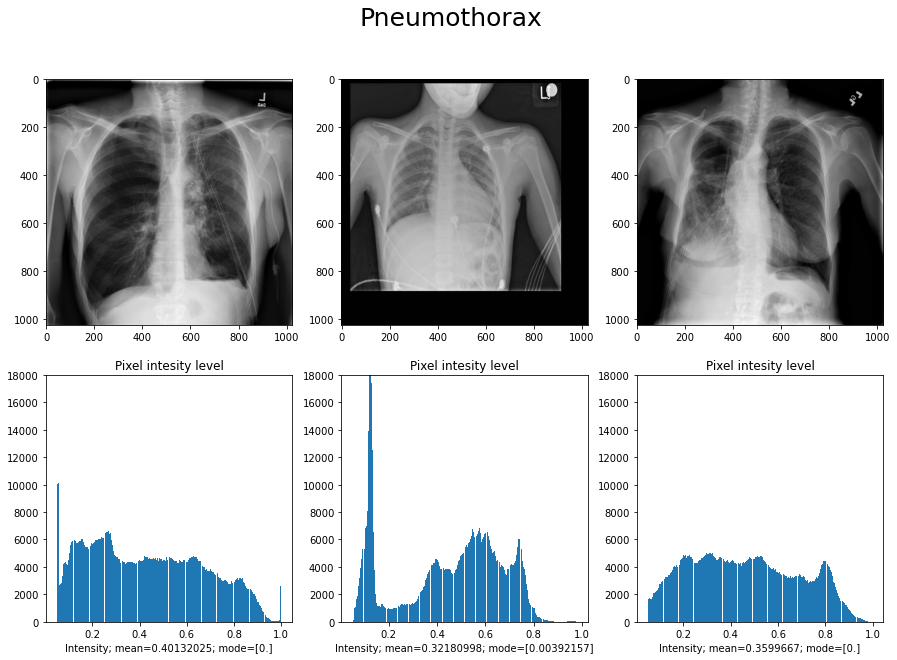

In [22]:
#plotting pixel intensity levels with xray image for various disease (with samples having only one disease/patient for better comparison)
#I have set y-axis limit to [0,18000], and masked low intesity background, so I can better compare different distributions 

for disease in sample_labels:
    
    sample_disease = sample_df[sample_df["Finding Labels"].str.match(disease)]     
    sample_disease = sample_disease.sample(3)
    data = []
    for p in range(len(sample_disease)):
        data.append((disease, sample_disease.iloc[p]["path"]))
    
    fig, a = plt.subplots(2,3, figsize=(15,10))
    fig.suptitle(disease, fontsize=25)
    
    for i in range(3):         #3 samples

        var = plt.imread(data[i][1])
        mask = var > 0.05                  #masked low intensity background (on intensity distribution)

        a[0][i].imshow(var, cmap='gray')            #image displayed without mask
        a[1][i].hist(var[mask].ravel(), bins=256)          #masked low intensity background (on intensity distribution)
        a[1][i].set_title('Pixel intesity level')
        a[1][i].set_ylim([0,18000])
        a[1][i].set_xlabel('Intensity; '+'mean='+ str(np.mean(var))+ '; mode='+ str(scipy.stats.mode(var, axis=None)[0]))

#### Looking at some of the samples of xray and pixel intensity distributions for various disease conditions, I find it quite hard to tell which label an image is associated with because the intensity distribution patterns are very similar for some of them. Here, I have selected samples with only one disease in 'finding labels'. 

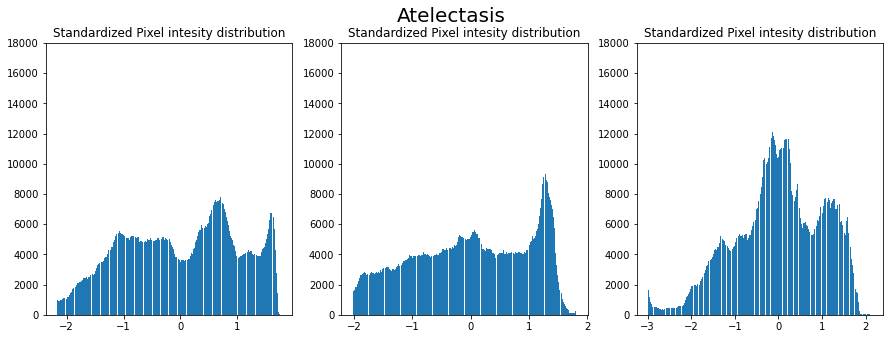

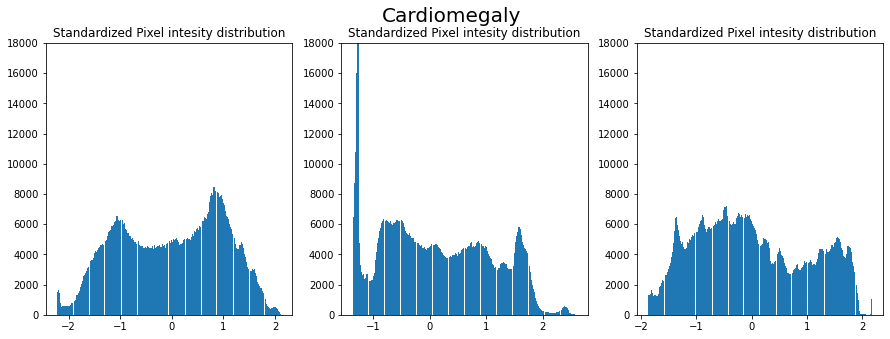

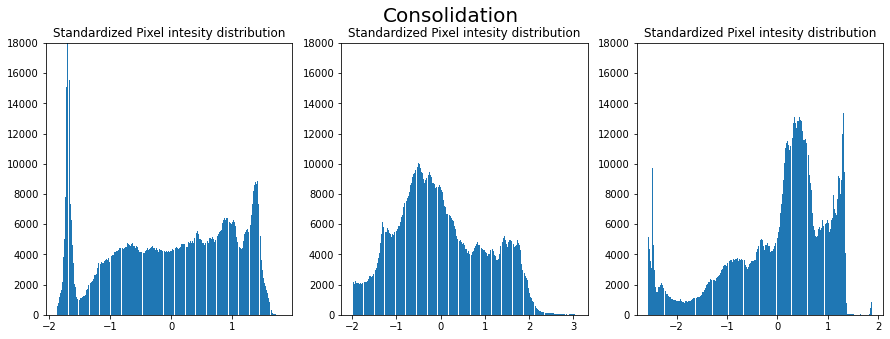

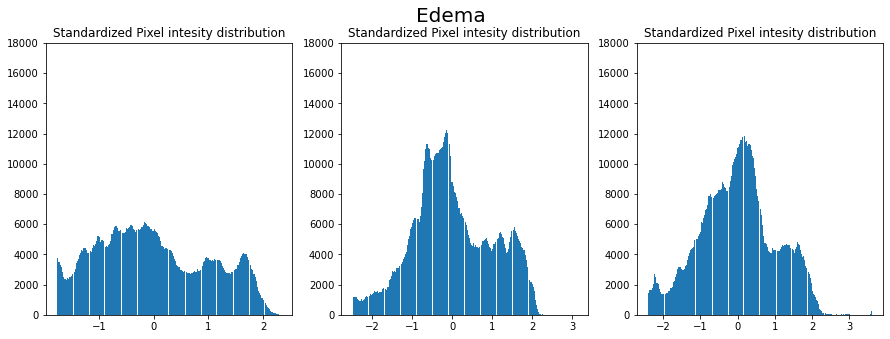

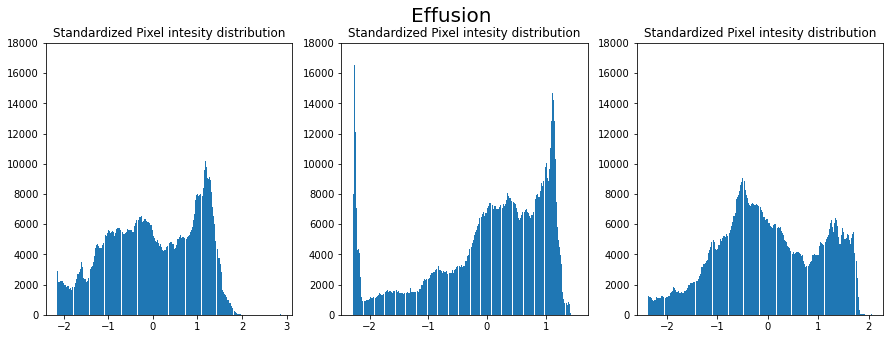

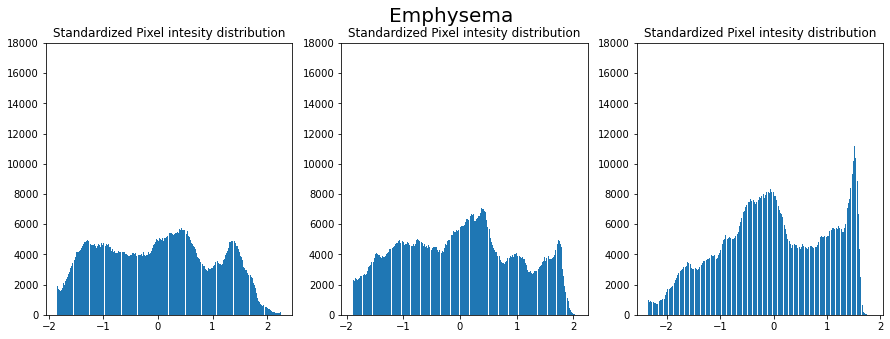

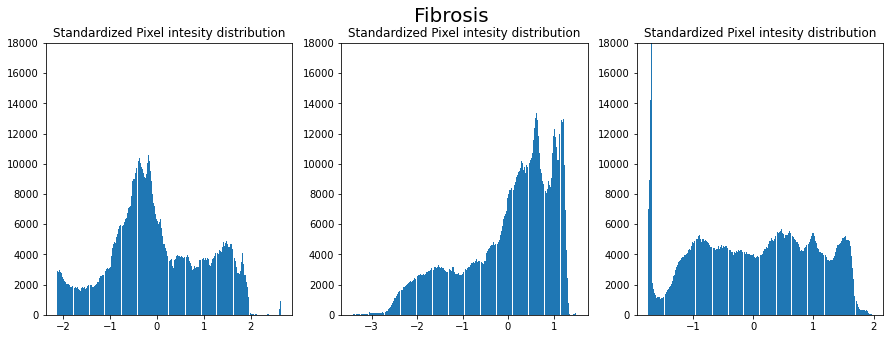

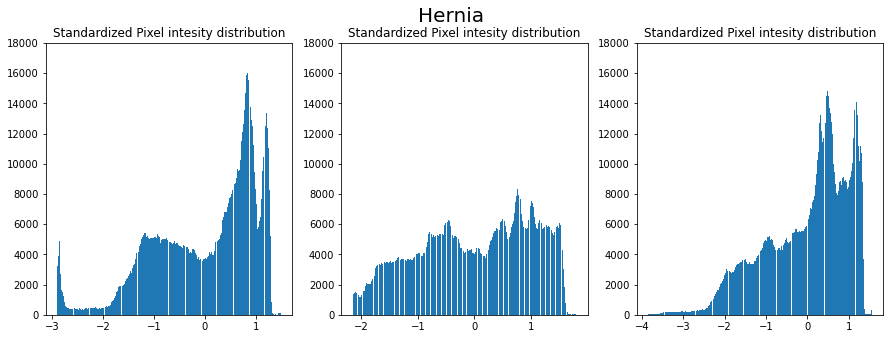

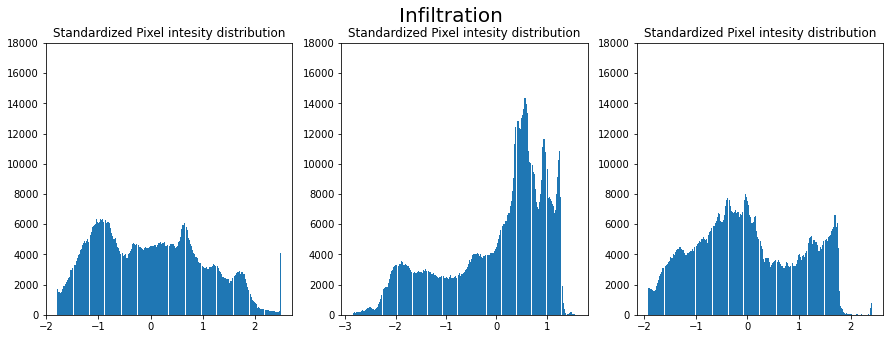

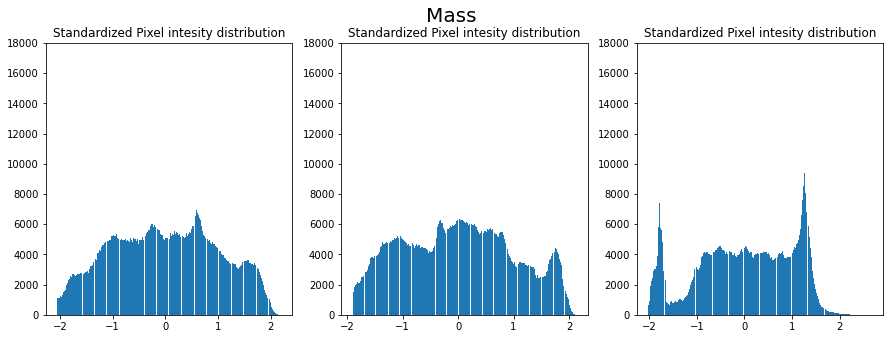

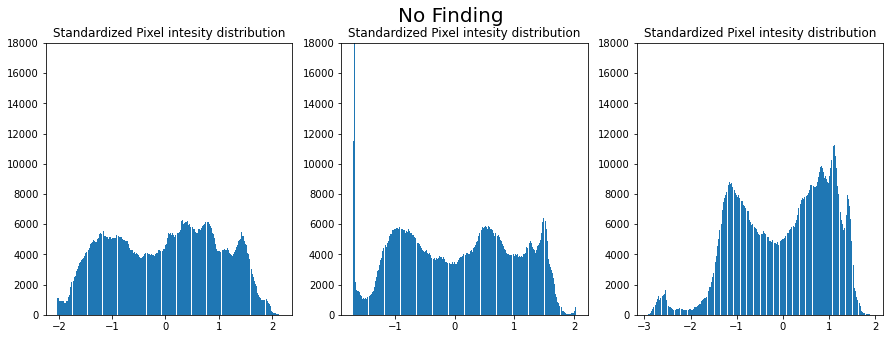

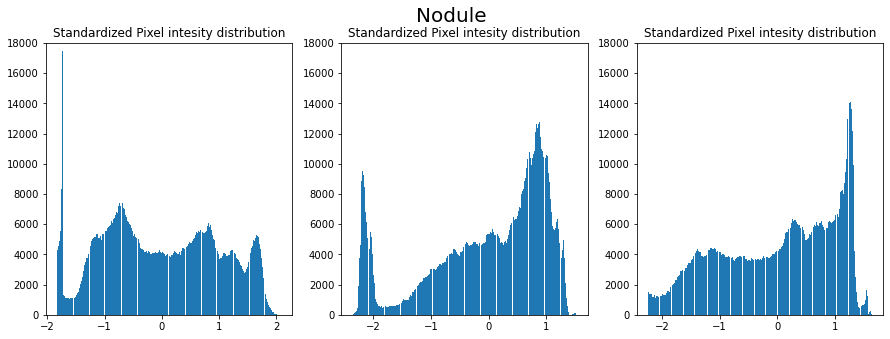

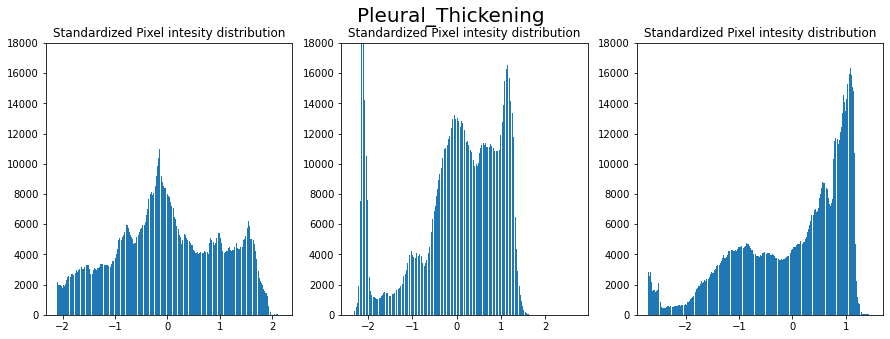

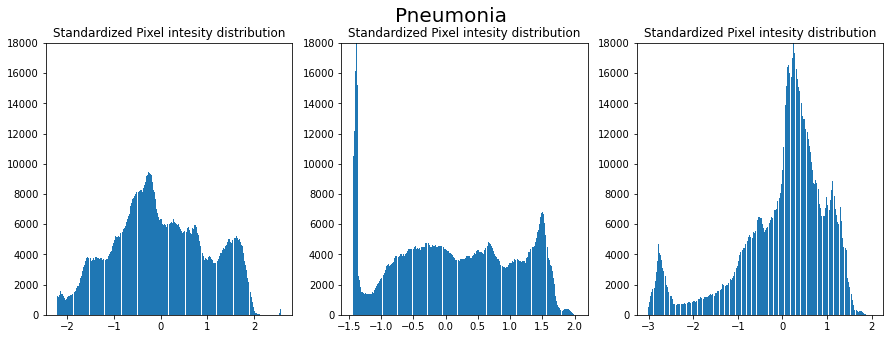

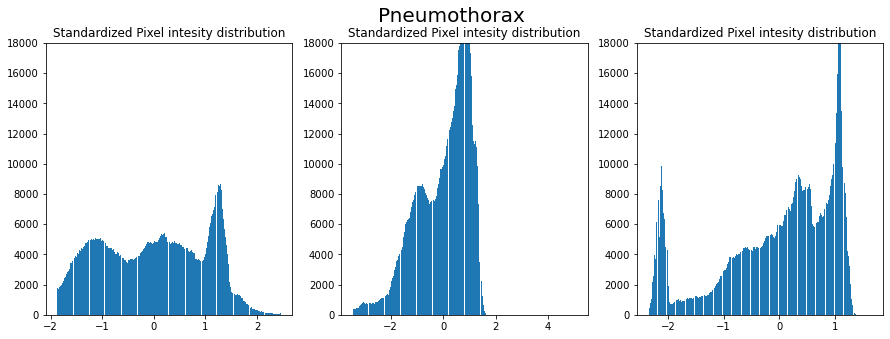

In [25]:
#plotting Standardized pixel intensity level distributions for various disease

for disease in sample_labels:
    
    sample_disease = sample_df[sample_df["Finding Labels"].str.match(disease)]
    sample_disease = sample_disease.sample(3)
    data = []
    for p in range(len(sample_disease)):
        data.append((disease, sample_disease.iloc[p]["path"]))
    
    fig, a = plt.subplots(1, 3, figsize=(15,5))
    fig.suptitle(disease, fontsize=20)
    
    for i in range(3):         #display 3 samples from 'data' for each disease

        var = plt.imread(data[i][1])
        mask = var > 0.05           #mask
        a[i].hist(((var[mask] - np.mean(var[mask]))/np.std(var[mask])).ravel(), bins=256)   #masked low intensity background
        a[i].set_title('Standardized Pixel intesity distribution')
        a[i].set_ylim([0,18000])

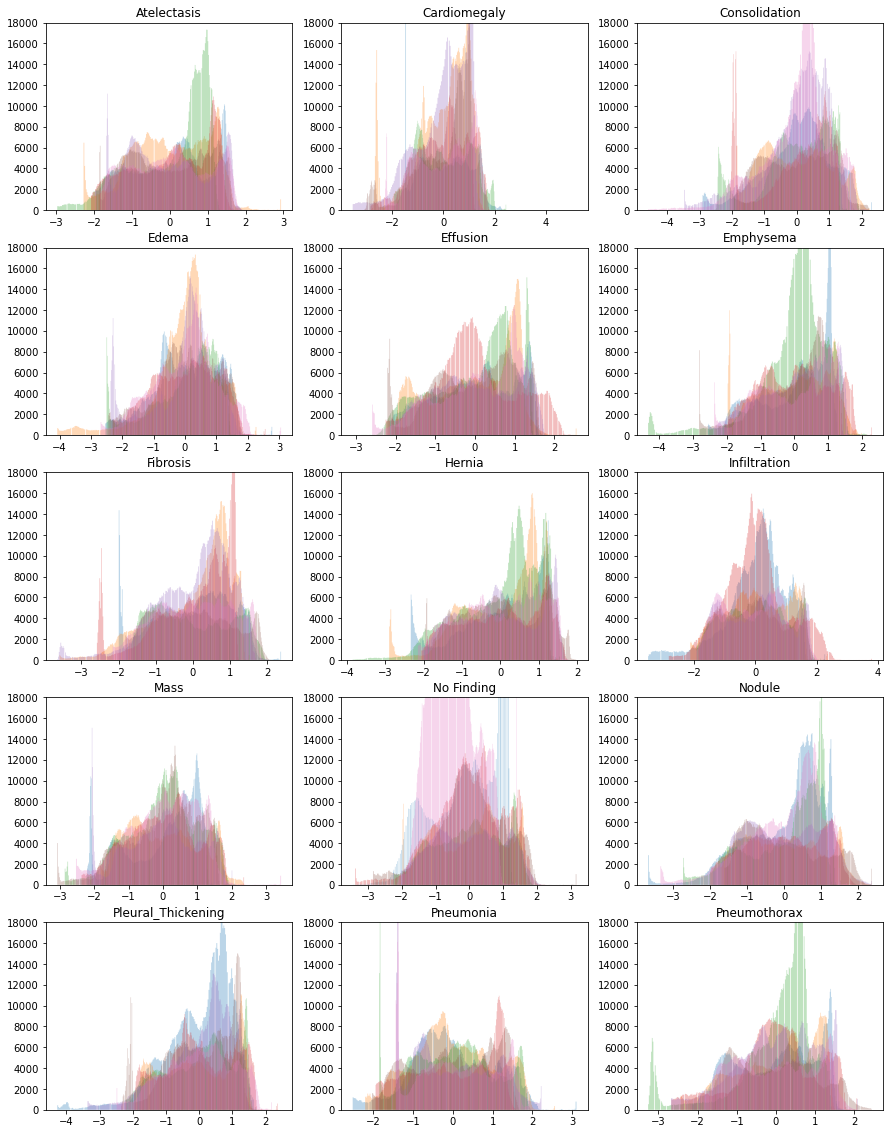

In [46]:
#plotting standardized pixel intensity level distributions for various disease, combining 5 samples from each disease to better
#look at the distribution. Reviewer's suggestion was to aggregrate all the samples for each disease, however, it was
#very slow, so I did it with 5 samples for each disease

fig = plt.figure(figsize=(15,20))

for x, disease in enumerate(sample_labels):
    
    sample_disease = sample_df[sample_df["Finding Labels"].str.match(disease)]
    sample_disease = sample_disease.sample(7)
    data = []
    for p in range(len(sample_disease)):
        data.append((disease, sample_disease.iloc[p]["path"]))
    
    ax = fig.add_subplot(5, 3, x+1)
    ax.set_title(disease)
    
    for i in range(7):         #combine 5 samples from 'data' for each disease

        var = plt.imread(data[i][1])
        mask = var > 0.05         #mask
        kwargs = dict(histtype='stepfilled', alpha=0.3, bins=256)       
        
        ax.hist(((var[mask] - np.mean(var[mask]))/np.std(var[mask])).ravel(), **kwargs)   #masked low intensity background
        ax.set_ylim([0,18000])

#### I have plotted standardized intesity levels above. Pneumonia seems to have a similarity with distributions for edema, atelectasis, and effusion. 
I looked at the discussion on original kaggle dataset and some radiologists have also mentioned that a lot of the labels that they looked at are incorrect. Looking at the original paper, these labels were extracted from radiology reports using natural language processing algorithm, so it is error prone (they have reported >90% accuracy).